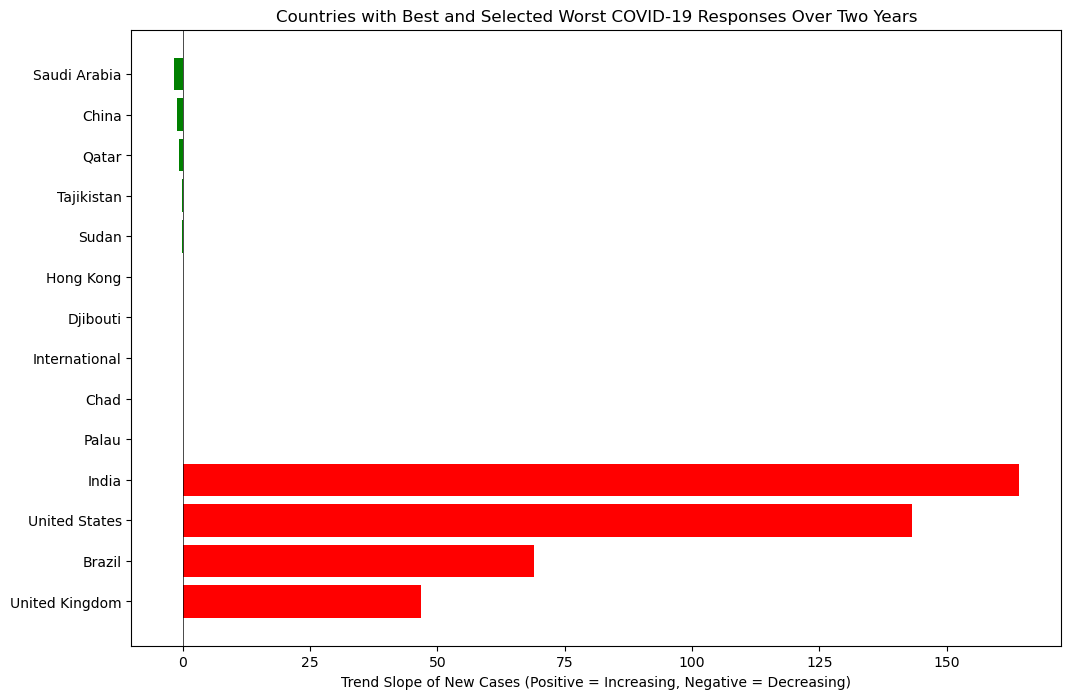

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# Load the COVID-19 data file
file_path = 'covid-data.csv'  # Update with the correct path in your environment
covid_data = pd.read_csv(file_path)

# Convert the 'date' column to datetime format
covid_data['date'] = pd.to_datetime(covid_data['date'])

# Filter data for a two-year period (2020-01-01 to 2022-01-01)
covid_data_two_years = covid_data[(covid_data['date'] >= '2020-01-01') & (covid_data['date'] <= '2022-01-01')]

# Define a function to calculate the trend (slope) in new cases
def calculate_trend(data):
    data = data.dropna(subset=['new_cases']).copy()  # Create a copy to avoid SettingWithCopyWarning
    data['days_since_start'] = (data['date'] - data['date'].min()).dt.days  # Calculate days since start
    if len(data) > 1:
        X = sm.add_constant(data['days_since_start'])
        model = sm.OLS(data['new_cases'], X).fit()
        return model.params['days_since_start']
    return np.nan

# Apply the function to each country to calculate trends, using include_groups=False to avoid the warning
trend_data = covid_data_two_years.groupby('location', group_keys=False).apply(calculate_trend, include_groups=False).reset_index()
trend_data.columns = ['location', 'case_trend']
trend_data['trend_classification'] = np.where(trend_data['case_trend'] > 0, 'Increasing',
                                              np.where(trend_data['case_trend'] < 0, 'Decreasing', 'Stable'))

# Filter for best response countries and selected worst response countries
best_response_countries = trend_data[trend_data['trend_classification'] == 'Decreasing'].sort_values(by='case_trend').head(10)
selected_worst_countries = ["India", "United States", "Brazil", "United Kingdom"]
worst_response_countries = trend_data[(trend_data['trend_classification'] == 'Increasing') & 
                                      (trend_data['location'].isin(selected_worst_countries))].sort_values(by='case_trend', ascending=False)

# Combine for visualization
best_worst_selected = pd.concat([best_response_countries, worst_response_countries])

# Plotting
plt.figure(figsize=(12, 8))
plt.barh(best_worst_selected['location'], best_worst_selected['case_trend'], 
         color=['green' if trend == 'Decreasing' else 'red' for trend in best_worst_selected['trend_classification']])
plt.xlabel("Trend Slope of New Cases (Positive = Increasing, Negative = Decreasing)")
plt.title("Countries with Best and Selected Worst COVID-19 Responses Over Two Years")
plt.axvline(0, color='black', linewidth=0.5)
plt.gca().invert_yaxis()  # Invert y-axis for readability
plt.show()
